# Hand Detection (side view) Using Mediapipe
Compiled by Kaitlin Pet

 The code below is adapted from the Mediapipe tutorial and their example notebook.

- tutorial: https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/python#live-stream

- Example notebook: https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb#scrollTo=OMjuVQiDYJKF


Mediapipe is compatable with OpenCV webcam, which makes it a good candidate for online implementation

I am able the side view is able to show us more detailed information on note onset, specifically:

- information with predictive value -- (i.e. a note onset will occur in n seconds)

-information with past value -- (i.e. a note onset has just happened)

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
# Requirements

!pip3 install opencv-python

! python -m pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 31.6 MB/s eta 0:00:00


In [7]:
#Imports

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import cv2
from google.colab.patches import cv2_imshow


BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

## Obtain off-the-shelf hand landmarker model

In [ ]:
#download off-the-shelf model

!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

## Function for visualizing hand landmark locations (from tutorial)

In [ ]:
# Visualization function: shows how to yield values from fitted model
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.

  #print("length of identified landmarks: ", len(hand_landmarks_list))
  for idx in range(len(hand_landmarks_list)):

    #print("*****\n idx is ", idx)
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]
    #print( hand_landmarks)

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

#Test 1: Anti-Alias Testing on Single Images

I suspect an aliasing issue. If we are going with hands alone, will have to address this with some sort of fine-tuning. I suggest pyramid downsample then pyramid upsample for new training images

Run cell to upload file to google collab

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
   content = uploaded[filename]
   with open(filename, 'wb') as f:
     f.write(content)

   if len(uploaded.keys()):
     IMG_FILE = next(iter(uploaded))
     print('Uploaded file:', IMG_FILE)

Saving side_piano_large.jpeg to side_piano_large.jpeg
Uploaded file: side_piano_large.jpeg


Create detector object

In [ ]:


# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)


No Preprocessing

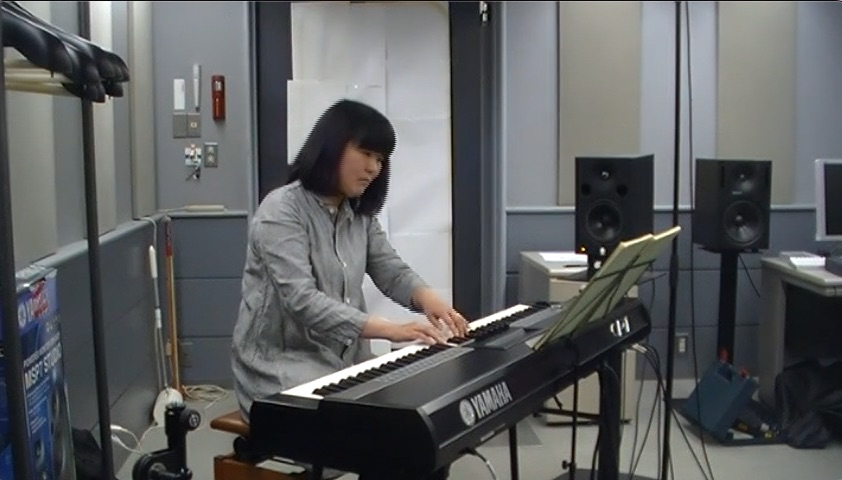

In [ ]:

# STEP 3: Load the input image.
image = cv2.imread(IMG_FILE)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the OpenCV image to a MediaPipe’s Image object.
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Cropped- still unstable but better!

(480, 842, 3)


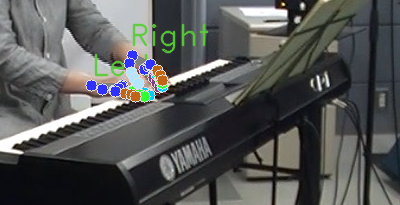

In [ ]:

# STEP 3: Load the input image.
image = cv2.imread(IMG_FILE)

print(image.shape)
image = image[245:450, 300:700, :]
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the OpenCV image to a MediaPipe’s Image object.
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Downsample then Upsample

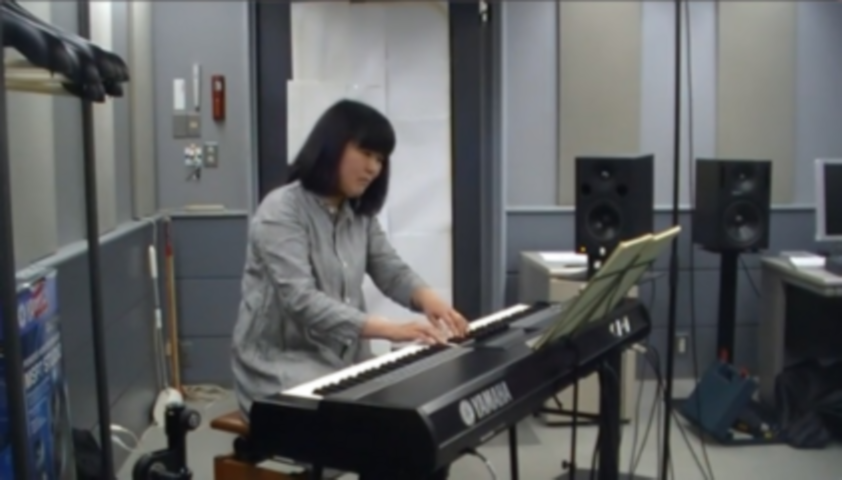

In [ ]:

# STEP 3: Load the input image.
image = cv2.imread(IMG_FILE)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#blue
#image = cv2.GaussianBlur(image, ksize= np.array([0, 0]), sigmaX=1, sigmaY=1)
    #downsample
image = cv2.pyrDown(image)
image = cv2.pyrUp(image)
    # Convert the OpenCV image to a MediaPipe’s Image object.
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)


# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Smaller size yielded by converting original PNG to smaller size jpeg. Some other downsampling algorithm used.

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
   content = uploaded[filename]
   with open(filename, 'wb') as f:
     f.write(content)

   if len(uploaded.keys()):
     IMG_FILE_SMALL = next(iter(uploaded))
     print('Uploaded file:', IMG_FILE_SMALL)

Saving side_piano.jpeg to side_piano (4).jpeg
Uploaded file: side_piano.jpeg


Only upsample

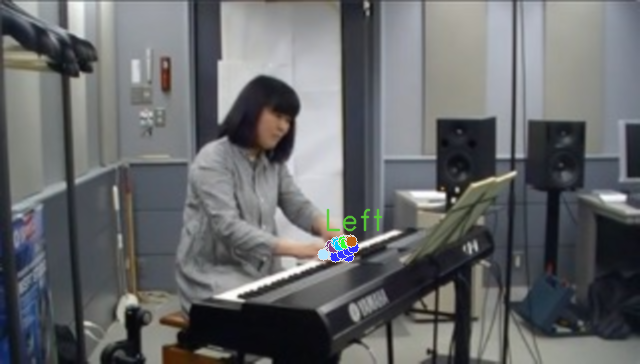

In [ ]:
image = cv2.imread(IMG_FILE_SMALL)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


image = cv2.pyrUp(image)
    # Convert the OpenCV image to a MediaPipe’s Image object.
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Downsample then upsample

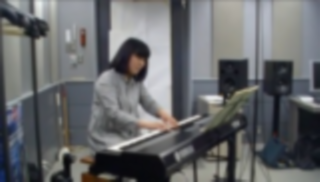

In [ ]:
image = cv2.imread(IMG_FILE_SMALL)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.pyrDown(image)
image = cv2.pyrUp(image)
    # Convert the OpenCV image to a MediaPipe’s Image object.
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

## Test a different image with less prominent aliasing

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
   content = uploaded[filename]
   with open(filename, 'wb') as f:
     f.write(content)

   if len(uploaded.keys()):
     IMG_FILE_2 = next(iter(uploaded))
     print('Uploaded file:', IMG_FILE_2)

Saving side_view_less_aliasing.jpeg to side_view_less_aliasing (1).jpeg
Uploaded file: side_view_less_aliasing.jpeg


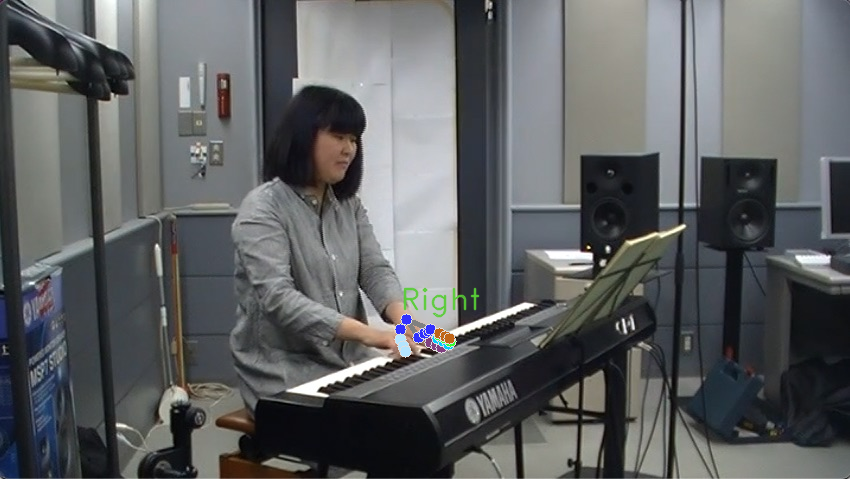

In [ ]:


# STEP 3: Load the input image.
image = cv2.imread(IMG_FILE_2)

#image = cv2.GaussianBlur(image, ksize= np.array([0, 0]), sigmaX=2, sigmaY=2)
    #downsample

image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the OpenCV image to a MediaPipe’s Image object.
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Downsample then Upsample removes landmarks

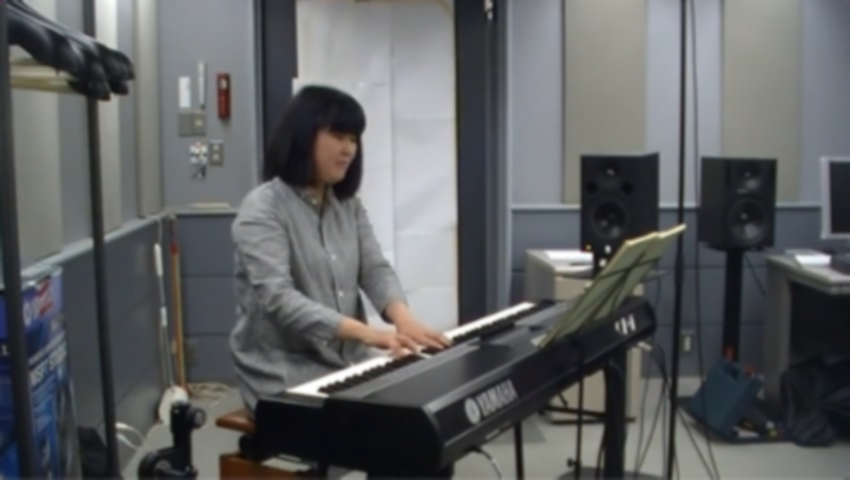

In [ ]:


# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = cv2.imread(IMG_FILE_2)

#image = cv2.GaussianBlur(image, ksize= np.array([0, 0]), sigmaX=2, sigmaY=2)
    #downsample
image = cv2.pyrDown(image)
image = cv2.pyrUp(image)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the OpenCV image to a MediaPipe’s Image object.
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Gaussian blur retains landmarks

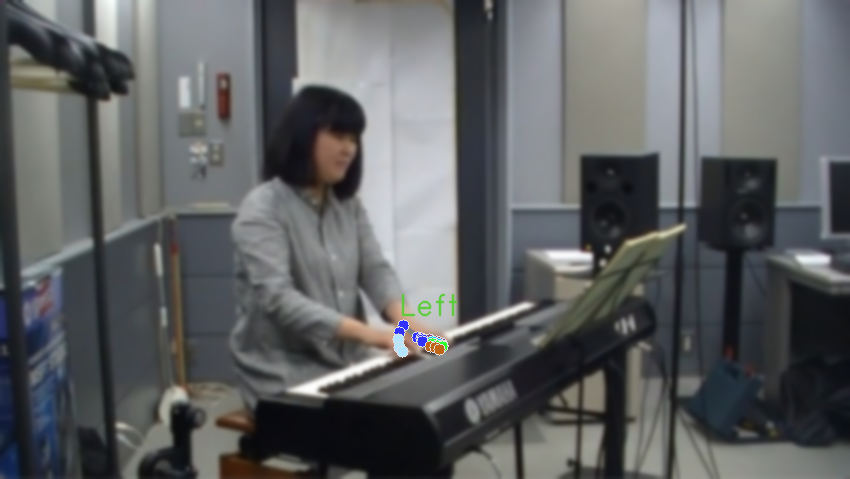

In [ ]:


# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = cv2.imread(IMG_FILE_2)

image = cv2.GaussianBlur(image, ksize= np.array([0, 0]), sigmaX=2, sigmaY=2)
    #downsample

image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the OpenCV image to a MediaPipe’s Image object.
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
   content = uploaded[filename]
   with open(filename, 'wb') as f:
     f.write(content)

   if len(uploaded.keys()):
     IMG_FILE_SMALL = next(iter(uploaded))
     print('Uploaded file:', IMG_FILE_SMALL)

Saving side_view_less_aliasing Small.jpeg to side_view_less_aliasing Small.jpeg
Uploaded file: side_view_less_aliasing Small.jpeg


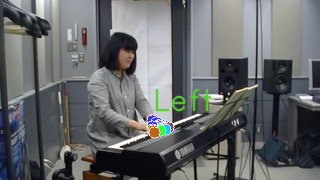

In [ ]:


# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMG_FILE_SMALL)
# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

# Test 2: Identify hands in video frames

-- I am guessing this has smoothing component, may help with ID

Upload video in Collab

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
   content = uploaded[filename]
   with open(filename, 'wb') as f:
     f.write(content)

   if len(uploaded.keys()):
     VID_FILE = next(iter(uploaded))
     print('Uploaded file:', VID_FILE)

Saving Debussy-Bateau-Eyecontact-1-1.mp4 to Debussy-Bateau-Eyecontact-1-1.mp4
Uploaded file: Debussy-Bateau-Eyecontact-1-1.mp4


## Initialize HandLandmarker model (detector) for video

In [ ]:


# STEP 2: Create an HandLandmarker object for video
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       running_mode=VisionRunningMode.VIDEO,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)




Turn video into OpenCV video capture object

In [ ]:
# Use OpenCV’s VideoCapture to load the input video.
cap = cv2.VideoCapture(VID_FILE)
# Load the frame rate of the video using OpenCV’s CV_CAP_PROP_FPS
# You’ll need it to calculate the timestamp for each frame.
fps = cap.get(cv2.CAP_PROP_FPS)

fpms = fps/1000
print("frames per ms", fpms)
total_num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("total frames in video", total_num_frames)


## Downsample
ret = cap.set(cv2.CAP_PROP_FRAME_WIDTH,320)
ret = cap.set(cv2.CAP_PROP_FRAME_HEIGHT,240)

frames per ms 0.02997002997002997
total frames in video 6765


Loop through each frame of the video and compute hand landmark locations.

Note: The Hand Landmarker model expects images in RGB format, while OpenCV defaults to BGR. Image must be converted before running model.

In [ ]:



# Loop through each frame in the video using VideoCapture#read()
cur_frame = 0
while cap.isOpened():
    ret, frame = cap.read()

    #need to convert to rgb before it can be processed
    frame= cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #downsample
    #frame = cv2.pyrDown(frame)
   # print(frame.shape)


    frame_timestamp_ms = int(cur_frame/fpms)
    #print(ret)
    # Convert the frame received from OpenCV to a MediaPipe’s Image object.
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)


    #for video

    # STEP 4: Detect hand landmarks from the video input.

    detection_result = detector.detect_for_video(mp_image, frame_timestamp_ms)

    # STEP 5: Process the classification result. In this case, visualize it.


    if cur_frame > 200 and cur_frame <225:
      annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)
      cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
    '''
    #for plain image
    detection_result = detector.detect(mp_image)

    # STEP 5: Process the classification result. In this case, visualize it.
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)
    cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
    '''
    if cur_frame==226:
      break


    cur_frame = cur_frame + 1 #update

cap.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

# Create demo video - no interpolation

In [ ]:


# STEP 2: Create an HandLandmarker object for video
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       running_mode=VisionRunningMode.VIDEO,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)




In [ ]:
# Use OpenCV’s VideoCapture to load the input video.
cap = cv2.VideoCapture(VID_FILE)
# Load the frame rate of the video using OpenCV’s CV_CAP_PROP_FPS
# You’ll need it to calculate the timestamp for each frame.
fps = cap.get(cv2.CAP_PROP_FPS)

fpms = fps/1000
print("frames per ms", fpms)
total_num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_num_frames


## get width and height
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

frames per ms 0.02997002997002997


Allow google write access to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Create output video

out = cv2.VideoWriter('/content/gdrive/My Drive/LABELED - Debussy-Bateau-Eyecontact-1-1.avi',
                      cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))


In [ ]:
all_landmarks = []

In [ ]:



# Loop through each frame in the video using VideoCapture#read()
cur_frame = 0
while cur_frame < total_num_frames:
    if cur_frame%500==0:
      print("processing", cur_frame/total_num_frames)
    ret, frame = cap.read()

    #need to convert to rgb before it can be processed
    frame= cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #downsample
    #frame = cv2.pyrDown(frame)
    #print(frame.shape)


    frame_timestamp_ms = int(cur_frame/fpms)
    #print(ret)
    # Convert the frame received from OpenCV to a MediaPipe’s Image object.
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)


    #for video

    # STEP 4: Detect hand landmarks from the video input.

    detection_result = detector.detect_for_video(mp_image, frame_timestamp_ms)

    # STEP 5: Process the classification result. In this case, visualize it.
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)

    #cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

    #Write to output
    out.write(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


    cur_frame = cur_frame + 1 #update

    #save information for processing

    all_landmarks.append(detection_result)

cap.release()
out.release()
cv2.destroyAllWindows()

processing 0.0
processing 0.07390983000739099
processing 0.14781966001478197
processing 0.22172949002217296
processing 0.29563932002956395
processing 0.36954915003695493
processing 0.4434589800443459
processing 0.5173688100517368
processing 0.5912786400591279
processing 0.6651884700665188
processing 0.7390983000739099
processing 0.8130081300813008
processing 0.8869179600886918
processing 0.9608277900960828


## Visualize Landmark positions and look for patterns

Each handLandmarker result can consist of 0, 1, or 2 hands.


Currently, a lot of missing data -- though two hands may be present in frame, cannot nessesarily be identified

In [ ]:
# Initialize storage data strucutre (want everything to be nan)

all_landmark_arr = np.zeros((2,total_num_frames, 21, 3))
#D1: left=0, right = 1
#D2: each frame of video
#D3: each landmark point
#D4: each dimension (x, y, z)

I'm going to assume that if only the right hand is visible, the 0th index will be the right hand.

In [ ]:
for curframe in range(total_num_frames):

  #Extract features
  detection_result = all_landmarks[curframe]
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness

  #Iterate through handdesness

  for hand_info in handedness_list:
    #print(hand_info)
    label = hand_info[0].category_name
    idx = hand_info[0].index

    #do check for only right hand present, index defaults to 0
    if len(handedness_list)==1 and label=="Right":
      idx=0

    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    #create array for landmark points
    allpoints = np.array([ np.array((landmark.x, landmark.y, landmark.z)) for landmark in hand_landmarks])

    #Add to array
    if label== "Left":
      all_landmark_arr[0, curframe, :, :]= allpoints

    if label=="Right":
      all_landmark_arr[1, curframe, :, :]=allpoints

## Plot to visualize, a lot of missing values.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
 rh_landmark1_x = all_landmark_arr[1, :, 1, 0]

NameError: ignored

In [ ]:
 rh_landmark1_y = all_landmark_arr[1, :, 1, 1]

In [ ]:
plt.plot( rh_landmark1_x, alpha=0.5)
#plt.plot( rh_landmark1_y, alpha=0.5)

plt.xlim(1000, 1100)

NameError: ignored

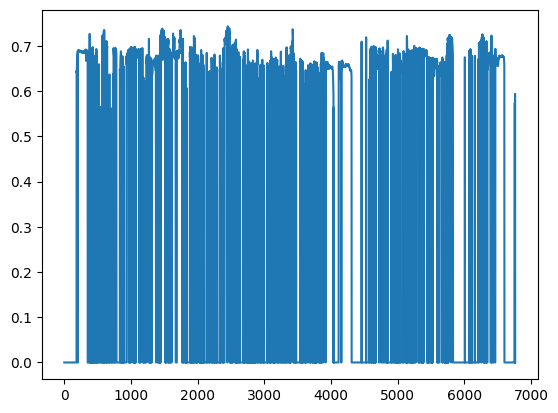

In [ ]:
plt.plot( rh_landmark1_y)

# Test: Deinterlaced

https://forum.videohelp.com/threads/405931-FFMPEG-Deinterlace

In [1]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
   content = uploaded[filename]
   with open(filename, 'wb') as f:
     f.write(content)

   if len(uploaded.keys()):
     VID_FILE = next(iter(uploaded))
     print('Uploaded file:', VID_FILE)

Saving OUT.mp4 to OUT.mp4
Uploaded file: OUT.mp4


# Body + Hands Detection

In this model, Mediapipe "holistic" uses a hirearchical model where the full body is first identified, then ROIs are extracted for the head and hands.



Code adapted from: https://github.com/google/mediapipe/blob/master/docs/solutions/holistic.md

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
   content = uploaded[filename]
   with open(filename, 'wb') as f:
     f.write(content)

   if len(uploaded.keys()):
     VID_FILE = next(iter(uploaded))
     print('Uploaded file:', VID_FILE)

KeyboardInterrupt: ignored

In [8]:
# Use OpenCV’s VideoCapture to load the input video.
cap = cv2.VideoCapture(VID_FILE)
# Load the frame rate of the video using OpenCV’s CV_CAP_PROP_FPS
# You’ll need it to calculate the timestamp for each frame.
fps = cap.get(cv2.CAP_PROP_FPS)

fpms = fps/1000
print("frames per ms", fpms)
total_num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("total frames in video", total_num_frames)



## get width and height
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

frames per ms 0.05994005994005994
total frames in video 13530


In [9]:
# Create output video

out = cv2.VideoWriter('/content/gdrive/My Drive/AllLandmarks-Debussy-Bateau-Eyecontact-1-1.avi',
                    cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))

In [10]:
all_landmarks = []

In [11]:
# Use OpenCV’s VideoCapture to load the input video.
cap = cv2.VideoCapture(VID_FILE)
# Load the frame rate of the video using OpenCV’s CV_CAP_PROP_FPS
# You’ll need it to calculate the timestamp for each frame.
fps = cap.get(cv2.CAP_PROP_FPS)

fpms = fps/1000
print("frames per ms", fpms)
total_num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("total frames in video", total_num_frames)



## get width and height
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

from google.colab.patches import cv2_imshow


# For video

idx = 0
with mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as holistic:
  while idx < total_num_frames:

    if idx %500 ==0:
      print("progess:", idx/total_num_frames)
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = holistic.process(image)

    all_landmarks.append(results)

    # Draw landmark annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_pose_landmarks_style())

    mp_drawing.draw_landmarks(
        image,
        results.left_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_hand_landmarks_style())

    mp_drawing.draw_landmarks(
        image,
        results.right_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_hand_landmarks_style())
    #save

    #cv2_imshow(image)
    out.write(image)



    idx = idx+1



cap.release()
out.release()

frames per ms 0.05994005994005994
total frames in video 13530
progess: 0.0
progess: 0.03695491500369549
progess: 0.07390983000739099
progess: 0.11086474501108648
progess: 0.14781966001478197
progess: 0.18477457501847747
progess: 0.22172949002217296
progess: 0.2586844050258684
progess: 0.29563932002956395
progess: 0.3325942350332594
progess: 0.36954915003695493
progess: 0.4065040650406504
progess: 0.4434589800443459
progess: 0.4804138950480414
progess: 0.5173688100517368
progess: 0.5543237250554324
progess: 0.5912786400591279
progess: 0.6282335550628233
progess: 0.6651884700665188
progess: 0.7021433850702143
progess: 0.7390983000739099
progess: 0.7760532150776053
progess: 0.8130081300813008
progess: 0.8499630450849963
progess: 0.8869179600886918
progess: 0.9238728750923872
progess: 0.9608277900960828
progess: 0.9977827050997783


# Save all landmarks

In [58]:
import pickle

In [61]:
all_pose_landmarks = []
for landmark_group in all_landmarks:
  landmark_cat = landmark_group.pose_landmarks #category
  if landmark_cat:
    landmark_cat = landmark_cat.landmark
    vis_landmark = [[landmark.x, landmark.y, landmark.z]#indevidual elements
                           for landmark in landmark_cat]
  else:
    vis_landmark = [None, None, None]

  all_pose_landmarks.append(vis_landmark)


#save

with open('debussy_eyecontact_pose_landmarks.pickle', 'wb') as handle:
    pickle.dump( all_pose_landmarks, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [62]:
all_lh_landmarks = []

landmark_cat_lst = all_lh_landmarks
for landmark_group in all_landmarks:
  landmark_cat = landmark_group.left_hand_landmarks #category
  if landmark_cat:
    landmark_cat = landmark_cat.landmark
    vis_landmark = [[landmark.x, landmark.y, landmark.z]#indevidual elements
                           for landmark in landmark_cat]
  else:
    vis_landmark = [None, None, None]

  landmark_cat_lst.append(vis_landmark)


#save

with open('debussy_eyecontact_lh_landmarks.pickle', 'wb') as handle:
    pickle.dump(landmark_cat_lst, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [66]:

all_rh_landmarks = []

landmark_cat_lst = all_rh_landmarks
for landmark_group in all_landmarks:
  landmark_cat = landmark_group.right_hand_landmarks #category
  if landmark_cat:
    landmark_cat = landmark_cat.landmark
    vis_landmark = [[landmark.x, landmark.y, landmark.z]#indevidual elements
                           for landmark in landmark_cat]
  else:
    vis_landmark = [None, None, None]

  landmark_cat_lst.append(vis_landmark)


#save

with open('debussy_eyecontact_rh_landmarks.pickle', 'wb') as handle:
    pickle.dump(landmark_cat_lst, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [64]:

all_face_landmarks = []

landmark_cat_lst = all_face_landmarks
for landmark_group in all_landmarks:
  landmark_cat = landmark_group.face_landmarks #category
  if landmark_cat:
    landmark_cat = landmark_cat.landmark
    vis_landmark = [[landmark.x, landmark.y, landmark.z]#indevidual elements
                           for landmark in landmark_cat]
  else:
    vis_landmark = [None, None, None]

  landmark_cat_lst.append(vis_landmark)


#save

with open('debussy_eyecontact_face_landmarks.pickle', 'wb') as handle:
    pickle.dump(landmark_cat_lst, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Vis vandmark by index

In [68]:
# Use OpenCV’s VideoCapture to load the input video.
cap = cv2.VideoCapture(VID_FILE)
# Load the frame rate of the video using OpenCV’s CV_CAP_PROP_FPS
# You’ll need it to calculate the timestamp for each frame.
fps = cap.get(cv2.CAP_PROP_FPS)

fpms = fps/1000
print("frames per ms", fpms)
total_num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("total frames in video", total_num_frames)



## get width and height
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

frames per ms 0.05994005994005994
total frames in video 13530


frames per ms 0.05994005994005994
total frames in video 13530
progess: 0.0
[[279.81188536 279.98062849 281.49004698 282.90640354 272.46525049
  268.24347496 264.22430277 273.07441235 248.88260365 279.18220997
  269.40903425 285.19467115 211.4256835  310.51676273 224.85352993
  349.23599482 300.03335953 365.3925705  321.1028409  363.68089199
  328.75591278 355.69226503 324.16680336 289.88690615 246.45194292
  377.24840641 359.72435474 341.58530474 312.59365082 325.36049366
  286.59780979 374.81489182 340.89067698]
 [159.93760586 149.08174038 148.95039082 148.64348888 148.21570873
  147.46376038 146.55049324 150.28325558 147.66932487 170.59397221
  169.50552464 201.66800022 214.66192245 277.17181206 311.1811924
  323.55734825 345.07856369 335.1492691  355.99522591 333.42464447
  346.70491219 330.45593262 343.95947456 372.02236176 389.36262131
  422.31883049 438.93977165 522.89892197 530.22422791 538.03979874
  539.7029686  556.21421814 574.32197571]]


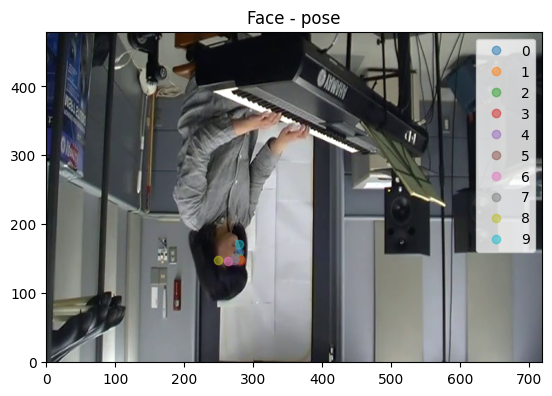

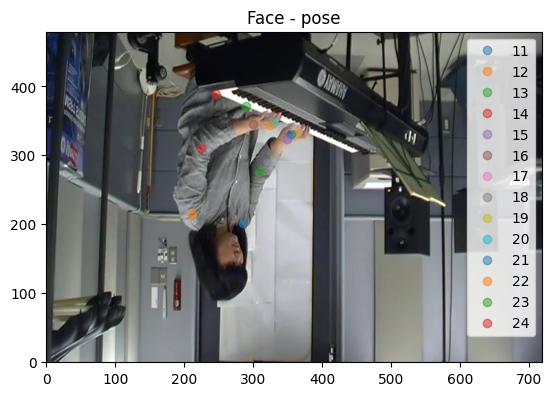

In [107]:
# Use OpenCV’s VideoCapture to load the input video.
cap = cv2.VideoCapture(VID_FILE)
# Load the frame rate of the video using OpenCV’s CV_CAP_PROP_FPS
# You’ll need it to calculate the timestamp for each frame.
fps = cap.get(cv2.CAP_PROP_FPS)

fpms = fps/1000
print("frames per ms", fpms)
total_num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("total frames in video", total_num_frames)



## get width and height
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

from google.colab.patches import cv2_imshow


# For video

idx = 0
with mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as holistic:
  while idx < total_num_frames:

    if idx %500 ==0:
      print("progess:", idx/total_num_frames)
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = holistic.process(image)


    # Custom landmark drawing - label with numbers

    if idx ==400:
      # Pose landmarks

      pose_landmarks = results.pose_landmarks.landmark

      pose_landmarks = np.array([np.array([landmark.x, landmark.y]) for
                                landmark in pose_landmarks ]).T

      pose_landmarks *=  np.array([[image.shape[1], image.shape[0]]]).T
      print(pose_landmarks)

      #FACE FROM POSE
      for point_idx in range(0,10):

        plt.plot(pose_landmarks[0][point_idx], pose_landmarks[1][point_idx] ,
                'o', label=point_idx, alpha = 0.5)


      plt.imshow(image, origin='lower')
      plt.legend()

      plt.title("Face - pose")
      plt.show()

      #BODY FROM POSE
      for point_idx in range(11,25):

        plt.plot(pose_landmarks[0][point_idx], pose_landmarks[1][point_idx] ,
                'o', label=point_idx, alpha = 0.5)


      plt.imshow(image, origin='lower')
      plt.legend()

      plt.title("Face - pose")
      plt.show()



      break







    idx = idx+1



cap.release()
out.release()

Wrists: 15 and 16

Shoudlers: 11 and 12

elbow: 13 and 14

# Graph landmark with midi onsets

Plot to see what correspodns to which feature

In [48]:
vis_landmark = np.array([np.array([landmark.x, landmark.y, landmark.z])
                           for landmark in all_pose_landmarks[0].landmark])

In [50]:
vis_landmark[:, 0]

array([0.41393632, 0.41196489, 0.4133541 , 0.41444066, 0.40214074,
       0.3961215 , 0.38996485, 0.39896792, 0.3655507 , 0.41080904,
       0.39970717, 0.39315805, 0.31982431, 0.41264823, 0.32178295,
       0.43897867, 0.40903044, 0.44598329, 0.42023832, 0.44815382,
       0.43148202, 0.44022781, 0.42645165, 0.39413795, 0.34947819,
       0.50291085, 0.5231123 , 0.46348408, 0.50880462, 0.44440925,
       0.4843049 , 0.50697249, 0.58009458])

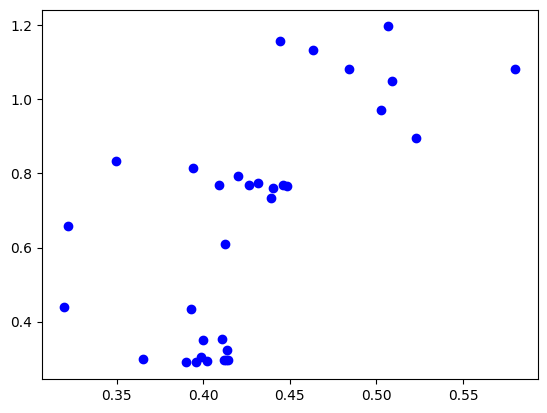

In [51]:
plt.plot(vis_landmark[:, 0], vis_landmark[:, 1], 'bo')

In [33]:
landmark_index = 1
landmark_lst = []
missing = 0
for landmark_group in all_landmarks:
  landmark_at_timestep= landmark_group.pose_landmarks

  if landmark_at_timestep:
    landmark_at_timestep = [[landmark.x, landmark.y, landmark.z]
                           for landmark in landmark_at_timestep.landmark]

    landmark_at_index = landmark_at_timestep[landmark_index]
  else:
    landmark_at_index= [None, None, None]
    missing = missing+1

  landmark_lst.append(landmark_at_index)
landmark_arr = np.array(landmark_lst)

In [34]:
landmark_arr

array([[0.41196489334106445, 0.2962656021118164, -0.22297604382038116],
       [0.4109025001525879, 0.2962143123149872, -0.19339455664157867],
       [0.41019150614738464, 0.2962082326412201, -0.1895616054534912],
       ...,
       [0.46394050121307373, 0.31007322669029236, -0.17684486508369446],
       [0.4647948443889618, 0.3103533685207367, -0.17499062418937683],
       [0.4655373990535736, 0.31052541732788086, -0.17880812287330627]],
      dtype=object)

In [35]:
missing

5

array([0.41196489334106445, 0.4109025001525879, 0.41019150614738464, ...,
       0.46394050121307373, 0.4647948443889618, 0.4655373990535736],
      dtype=object)

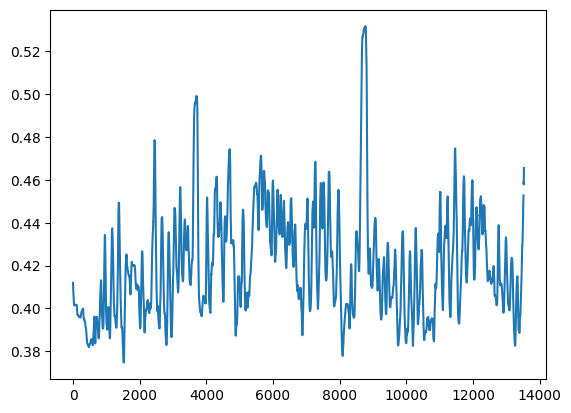

In [42]:
plt.plot(landmark_arr[:, 0])

In [22]:
def get_landmark_seq(landmark_over_time, landmark_index):

  landmark_lst = []
  missing = 0
  for i in range(len(landmark_over_time)):
    landmark_at_timestep = landmark_over_time[i]

    if landmark_at_timestep:
      landmark_at_index = landmark_at_timestep[landmark_index]
      xyz = [landmark_at_index.x, landmark_at_index.y, landmark_at_index.z]
    else:
      landmark_xyz = [None, None, None]
      missing = missing+1

    landmark_lst = landmark_lst.append(landmark_xyz)


  return landmark_lst, missing/len(landmark_over_time)



In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
pose_landmarks = np.array([[landmark.x, landmark.y, landmark.z]
                           for landmark in all_landmarks[0].pose_landmarks.landmark])

In [18]:
pose_landmarks

array([[ 0.41393632,  0.32388216, -0.25663459],
       [ 0.41196489,  0.2962656 , -0.22297604],
       [ 0.4133541 ,  0.29602903, -0.2230978 ],
       [ 0.41444066,  0.29582018, -0.22322576],
       [ 0.40214074,  0.29362744, -0.25649148],
       [ 0.3961215 ,  0.29154998, -0.25656486],
       [ 0.38996485,  0.28967845, -0.25661337],
       [ 0.39896792,  0.30330569, -0.05705812],
       [ 0.3655507 ,  0.2986812 , -0.20370261],
       [ 0.41080904,  0.35172701, -0.19106866],
       [ 0.39970717,  0.35037261, -0.23316354],
       [ 0.39315805,  0.4342868 ,  0.15782134],
       [ 0.31982431,  0.44026253, -0.28966826],
       [ 0.41264823,  0.60884356,  0.21300834],
       [ 0.32178295,  0.65832478, -0.31728828],
       [ 0.43897867,  0.73422551,  0.08655822],
       [ 0.40903044,  0.76783359, -0.27717119],
       [ 0.44598329,  0.76790065,  0.07390765],
       [ 0.42023832,  0.79279572, -0.31104144],
       [ 0.44815382,  0.76699382,  0.04592587],
       [ 0.43148202,  0.77486128, -0.303

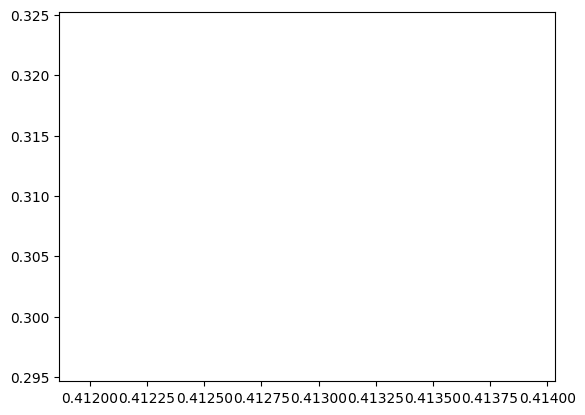

In [21]:
for i in range(len(pose_landmarks[0])):
  plt.plot(pose_landmarks[i][0], pose_landmarks[i][1])



# Obtain midi onsets

reference code: https://www.kaggle.com/code/wfaria/midi-music-data-extraction-using-music21

In [ ]:
# Analysis imports
!pip install music21

import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import music21

In [ ]:
# Read in midi

debussy_score = music21.converter.parse(
    '/content/gdrive/My Drive/Debussy-Bateau-Eyecontact-1.mid')



In [ ]:
mf = music21.midi.MidiFile()

mf.open('/content/gdrive/My Drive/debussy-1.mid')

mf.read()
mf.close()

track = mf.tracks[0]

total_ticks = 0
for event in track.events:
  if type(event)==music21.midi.DeltaTime:
    #print(event.time)
    total_ticks = total_ticks + event.time

In [ ]:
total_ticks

212160

In [ ]:
mf.ticksPerQuarterNote

480

In [ ]:
track.index

<function MidiTrack.index(value, start=0, stop=9223372036854775807, /)>

In [ ]:
test_stream = music21.midi.translate.midiFileToStream(mf)

In [ ]:
def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)

    return ret, parent_element

## Extract times with mido

https://mido.readthedocs.io/en/latest/midi_files.html

In [ ]:
!pip install mido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
from mido import MidiFile
from mido import tick2second

In [ ]:
mid = MidiFile('/content/gdrive/My Drive/debussy_eyecontact_1.mid')

#mid.ticks_per_beat=1000

In [ ]:
tpb = mid.ticks_per_beat

In [ ]:
tpb

480

Get tempo

In [ ]:
for i, track in enumerate(mid.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:
      if  msg.is_meta:
          #if msg.type == "note_on":

            print(msg)

Track 0: MIDI Take2.MID
MetaMessage('channel_prefix', channel=0, time=0)
MetaMessage('track_name', name='MIDI Take2.MID', time=0)
MetaMessage('instrument_name', name='Steinway Grand Piano', time=0)
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('smpte_offset', frame_rate=24, hours=32, minutes=0, seconds=0, frames=0, sub_frames=0, time=0)
MetaMessage('set_tempo', tempo=500000, time=0)
MetaMessage('end_of_track', time=1791)


In [ ]:
#FROM LOGIC FILE: aligned midi starts at 8.2958 seconds

midi_start = 11.832



In [ ]:
tempo = 500000

In [ ]:
time=0#midi_start
midi_ticks = 0
note_on_times = []
note_on_ticks = []
ticks = 0
pitches = []
for i, track in enumerate(mid.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:

      midi_ticks += msg.time
      time = time +  tick2second(msg.time, tpb, tempo)
      if not  msg.is_meta:
          #print("******")
          #print(msg)
          #print(time)

          if msg.type == "note_on":
            if msg.velocity >0: #actual onset
              note_on_times.append(time)
              note_on_ticks.append(midi_ticks)
              pitches.append(msg.note)







Track 0: MIDI Take2.MID


In [ ]:
pitches[0:10]

[83, 71, 74, 79, 76, 71, 81, 79, 83, 74]

In [ ]:
note_on_times[0:10]

[1.2906250000000001,
 2.19375,
 2.207291666666667,
 3.060416666666667,
 3.933333333333333,
 3.942708333333333,
 4.269791666666666,
 4.565624999999999,
 4.904166666666665,
 5.808333333333325]

This method has less rounding error

In [ ]:
note_on_times = np.array([tick2second(tick, tpb, tempo) for tick in note_on_ticks])

In [ ]:
note_on_times

array([  1.290625  ,   2.19375   ,   2.20729167,   3.06041667,
         3.93333333,   3.94270833,   4.26979167,   4.565625  ,
         4.90416667,   5.80833333,   5.82604167,   6.63020833,
         7.56770833,   7.584375  ,   7.86979167,   8.16145833,
         8.48333333,   9.38020833,   9.38645833,  11.12916667,
        11.13125   ,  12.84270833,  12.85208333,  14.58333333,
        14.596875  ,  15.425     ,  15.446875  ,  15.45625   ,
        17.98958333,  18.00625   ,  18.33958333,  18.64375   ,
        18.95625   ,  18.96770833,  21.59479167,  21.61458333,
        21.61458333,  22.55729167,  23.40520833,  23.415625  ,
        23.43333333,  23.68645833,  23.709375  ,  23.71770833,
        23.98958333,  23.99791667,  25.178125  ,  25.19270833,
        25.19791667,  25.490625  ,  25.51041667,  25.51354167,
        25.79479167,  25.79583333,  26.09375   ,  26.10208333,
        26.11458333,  26.39895833,  26.428125  ,  26.43541667,
        26.70104167,  26.71354167,  27.0375    ,  27.05

RE-normalize to midi start time according to video

In [ ]:
note_on_times = note_on_times - note_on_times[0]+midi_start

In [ ]:
note_on_times

array([ 11.832     ,  12.735125  ,  12.74866667,  13.60179167,
        14.47470833,  14.48408333,  14.81116667,  15.107     ,
        15.44554167,  16.34970833,  16.36741667,  17.17158333,
        18.10908333,  18.12575   ,  18.41116667,  18.70283333,
        19.02470833,  19.92158333,  19.92783333,  21.67054167,
        21.672625  ,  23.38408333,  23.39345833,  25.12470833,
        25.13825   ,  25.966375  ,  25.98825   ,  25.997625  ,
        28.53095833,  28.547625  ,  28.88095833,  29.185125  ,
        29.497625  ,  29.50908333,  32.13616667,  32.15595833,
        32.15595833,  33.09866667,  33.94658333,  33.957     ,
        33.97470833,  34.22783333,  34.25075   ,  34.25908333,
        34.53095833,  34.53929167,  35.7195    ,  35.73408333,
        35.73929167,  36.032     ,  36.05179167,  36.05491667,
        36.33616667,  36.33720833,  36.635125  ,  36.64345833,
        36.65595833,  36.94033333,  36.9695    ,  36.97679167,
        37.24241667,  37.25491667,  37.578875  ,  37.59

# Top View Piano Detection

Move to different notebook when you get a chance, not on theme

## Possibility 1: Hough Lines Transform
https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

In [ ]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
   content = uploaded[filename]
   with open(filename, 'wb') as f:
     f.write(content)

   if len(uploaded.keys()):
     VID_FILE = next(iter(uploaded))
     print('Uploaded file:', VID_FILE)

Saving Screen Shot 2023-06-17 at 10.48.20 AM.png to Screen Shot 2023-06-17 at 10.48.20 AM.png
Uploaded file: Screen Shot 2023-06-17 at 10.48.20 AM.png


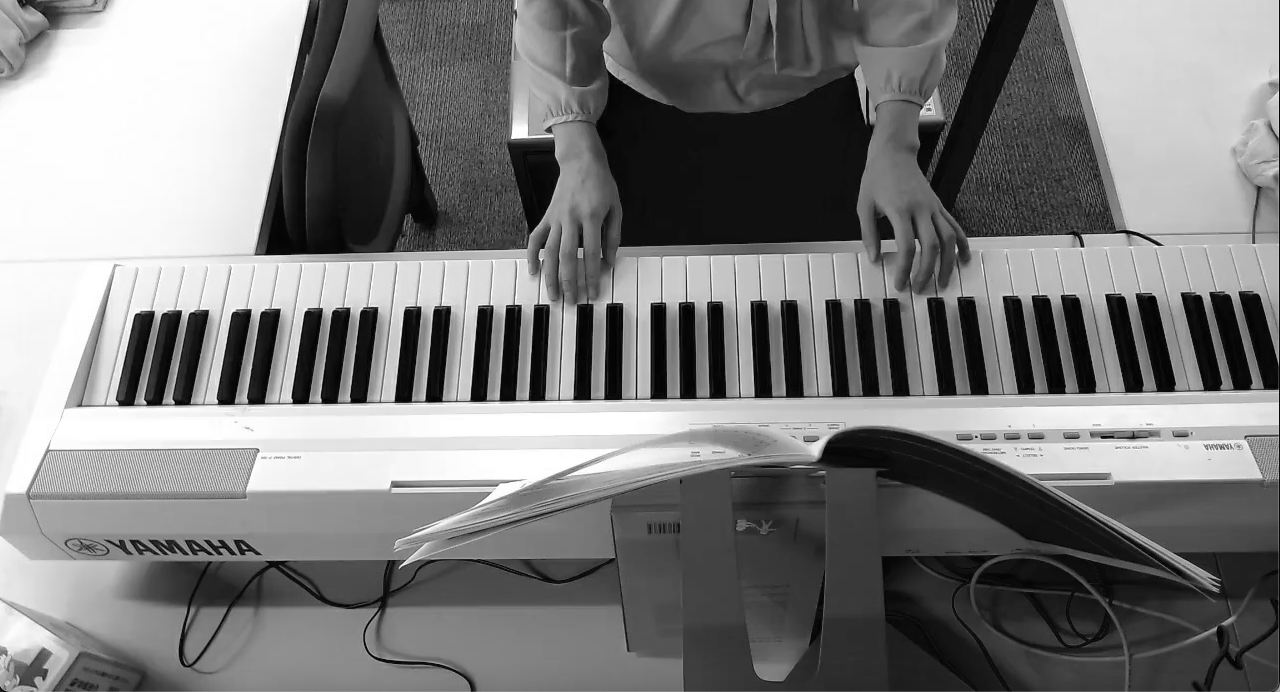

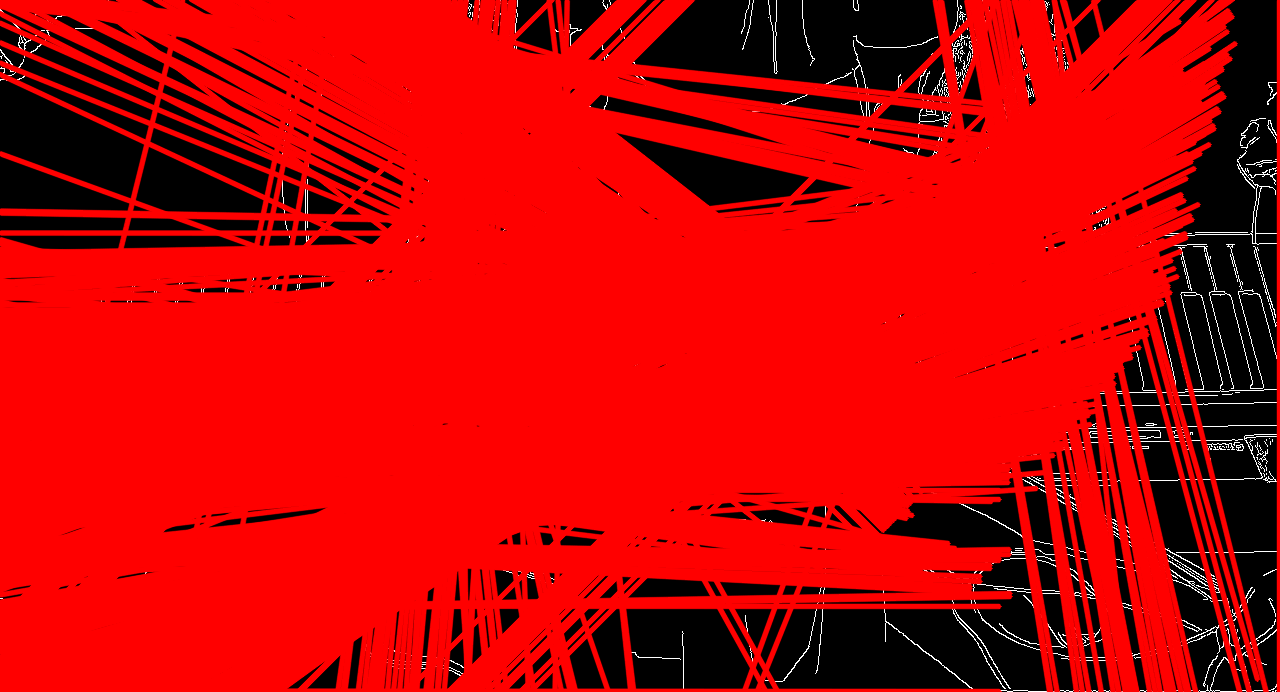

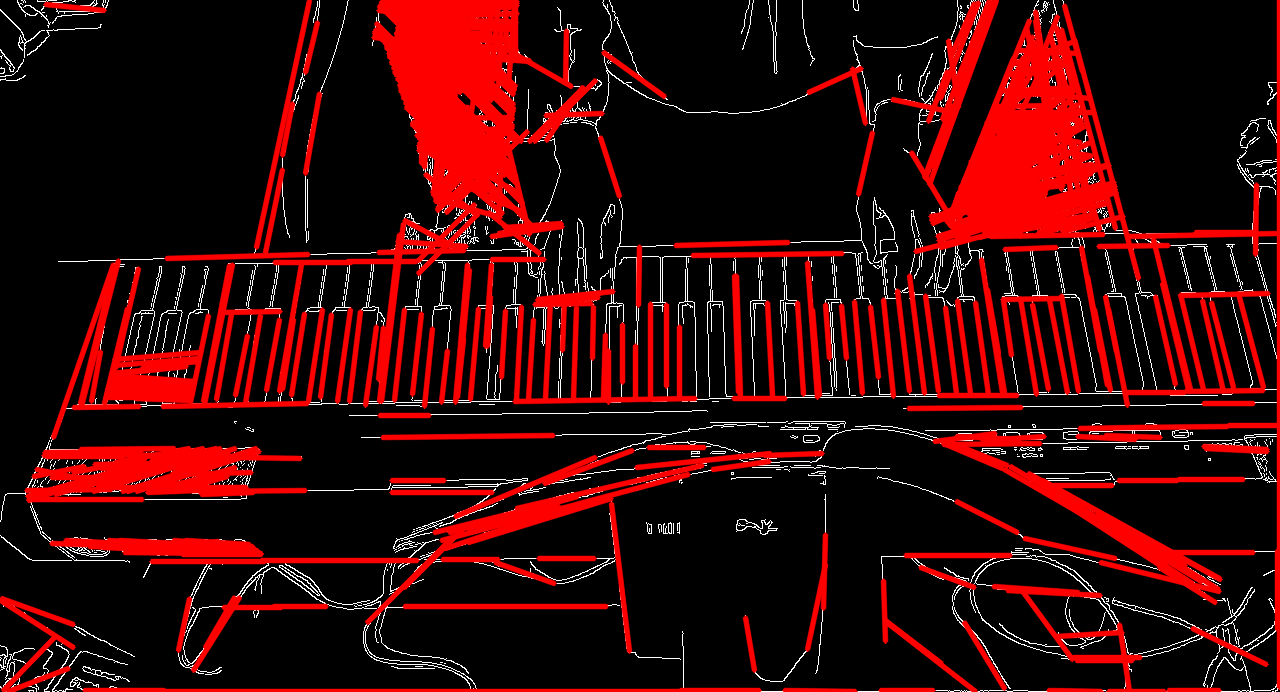

In [ ]:
import sys
import math
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

filename = VID_FILE
# Loads an image
src = cv.imread(cv.samples.findFile(filename), cv.IMREAD_GRAYSCALE)



dst = cv.Canny(src, 50, 200, 4, 3)

# Copy edges to the images that will display the results in BGR
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

lines = cv.HoughLines(dst, 1, np.pi / 180, 150, 1000, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)


linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, 1000
                        , 50, 10)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

cv2_imshow( src)
cv2_imshow(cdst)
cv2_imshow( cdstP)




## Template match

We can assume a certain *orientation*, *size*, and *horizontal position* of the piano based on hand placement and size

Then can probably go off template match since we have ballpark

Good because we can get partial template match

- Assume palm length can be between 3 and 7 keys wide
- **It would not be unreasonable to ask the pianist to do a calibration step where they assume a neutral postion: 1 key length per finger**
- knuckles (avg both hands) used to determine orientation
-



Procedure:
1. Determine approx orientation using finger pointing direction as width and knuckle line as parallel to length

2. Determine approx length of piano as avg. finger distance * 88

3. Assume standard width based on length

4. Using above params for initialization, match template of piano by gradient descent with affine transforms
  - params to descend: length, top corner, angle.
  - match template SSE loss/area
5. We want to bound the search explicity, then just choose minimum